In [64]:

#import packages

import os

import pandas as pd
from pandas import DataFrame
import numpy as np

import itertools

import datetime
from datetime import date

import matplotlib as mpl
import matplotlib.pylab as plt
plt.style.use('default')

from nltk.probability import FreqDist

from scipy import stats

#!pip install sklearn
import sklearn

from sklearn.cluster import KMeans

from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import cdist


from nltk import ngrams
from wordcloud import WordCloud

pd.options.display.float_format = '{:0,f}'.format

#initialize todays's date
today = date.today()

from IPython.display import HTML


In [2]:


import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download()



showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [303]:

#read the csv file into a dataframe
# in order to run move the dataset into the current working directory

#print the current working directory
os.getcwd()

bank_df = pd.read_csv("bank_ds_data.csv")


In [305]:

# look at the structure of the dataframe

bank_df.head(20)


,original_description,amount
0,COMCAST 7041,19855
1,Preauthorized Debit STATE FARM RO 2,8294
2,Preauthorized Debit COMENITY PAY SB,10996
3,Subscription Acorns ***********NUMBER,942
4,Best Buy #1530,302
5,BESTBUYCOMNUMBER 03/17 PURCHASE 888-BESTBUY MN,30144
6,Subscription DES:Acorns ID:HASH INDN:CUSTOMER ...,314
7,AT&T,37699
8,PROGRESSIVE *INSURANCE 06/26 PURCHASE 800-776-...,130056
9,AT&T*BILL PAYMENT 214-721-3650 TX 0...,30473


In [306]:

# compile summary stats on the amount of each transaction

bank_df.describe()['amount']



count       1,902.000000
mean       23,753.053628
std        50,305.956103
min            31.000000
25%         3,138.000000
50%         7,851.000000
75%        29,772.250000
max     1,256,323.000000
Name: amount, dtype: float64

{'whiskers': [<matplotlib.lines.Line2D at 0x14bbc1350>,
 'caps': [<matplotlib.lines.Line2D at 0x14bc5d550>,
 'boxes': [<matplotlib.lines.Line2D at 0x14bc0bad0>],
 'medians': [<matplotlib.lines.Line2D at 0x14bc5e690>],
 'fliers': [<matplotlib.lines.Line2D at 0x14bc5ee90>],
 'means': []}

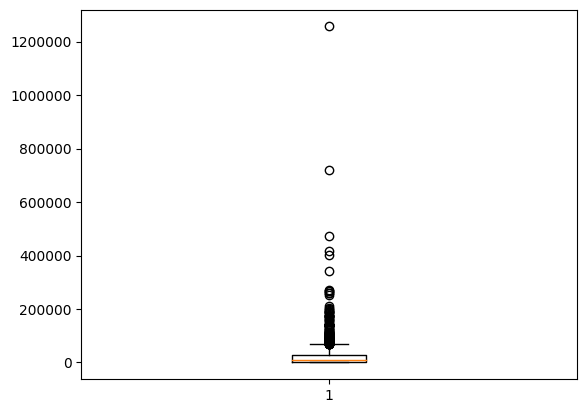

In [307]:

#Plot the distribution of price

plt.ticklabel_format(style='plain', useOffset=False, axis='y')
plt.boxplot(bank_df['amount'])





The box plox shows there are quite a few outliers that are outside of the Interquantile range (75%).


In [308]:

# print the median and the quantiles at 25% intervals

print(bank_df['amount'].median())
np.quantile(bank_df['amount'], q = (.25, .5, .75))
np.quantile(bank_df['amount'], q = (.05, .95))


7851.0


array([  625.  , 87928.55])

In [309]:

# use the quantiles to calculate the interquantile range 
# the interquantile range will then be used to extract the outliers from the dataframe

quantile_05 = np.quantile(bank_df['amount'], q = .05)
quantile_25 = np.quantile(bank_df['amount'], q = .25)
quantile_75 = np.quantile(bank_df['amount'], q = .75)

iqr_value = quantile_75 - quantile_25

lower_outliers = bank_df[(bank_df['amount']) < (quantile_25 - (1.5 * iqr_value))]
upper_outliers = bank_df[(bank_df['amount']) > (quantile_75 + (1.5 * iqr_value))]

# merge the lower and the upper outlier dataframes

# using the IQR there were no outliers that met the lower bound threshold
# but anticipating ease of reproducibility, the lower 5% threshold will also 
# be concatenated within the outlier database

lower_5_outliers = bank_df[(bank_df['amount']) < (quantile_05)]
bank_outliers = pd.concat([lower_5_outliers, lower_outliers, upper_outliers])


bank_outliers

In [311]:

# the resulting outlier dataframe has 199 observations making up ~ 10.463% of the total dataset

print(str(round(len(bank_outliers) / len(bank_df) *100, 3)) + '%')


10.463%


In [312]:

# remove the observations from the original bank_df that are in the outlier df

bank_df = bank_df[~bank_df.isin(bank_outliers)].dropna()
print(len(bank_df))
print(len(bank_outliers))


1703
199


In [313]:

# Create a dictionary of stop words to eliminate from the original_description
# tokenize the words in the description to make uniform text comparisons

eng_stopwords = set(stopwords.words('english'))


In [314]:

# Remove Stopwords Function

# create one and two token columns
# filter out stop words

def remove_token_stopwords(dataframe, column_to_tokenize, stopwords_list):
    temp_empty = []
    for index, row in dataframe.iterrows():
        row[column_to_tokenize] = row[column_to_tokenize].lower()
        row['token'] = word_tokenize(row[column_to_tokenize])
           # for word in row['token']:
        for word in stopwords_list:
            for element in row['token']:
                if word == element:
                    row['token'].remove(word)
        temp_empty.append(row)
    temp_empty = pd.DataFrame(temp_empty)
    return(temp_empty)



bank_outlier_tokens = remove_token_stopwords(bank_outliers, 'original_description', eng_stopwords)
bank_full_tokens = remove_token_stopwords(bank_df, 'original_description', eng_stopwords)

bank_outlier_tokens

,original_description,amount,token
4,best buy #1530,302,"[best, buy, #, 1530]"
6,subscription des:acorns id:hash indn:customer ...,314,"[subscription, des, :, acorns, id, :, hash, in..."
55,google*google storag g.co helppay#,311,"[google, *, google, storag, g.co, helppay, #]"
105,subscription des:acorns id:hash indn:customer ...,314,"[subscription, des, :, acorns, id, :, hash, in..."
108,google services,346,"[google, services]"
...,...,...,...
1844,state farm insurancebloomington il,74214,"[state, farm, insurancebloomington, il]"
1856,affirm.com payme affirm.com st-hash web id: nu...,77180,"[affirm.com, payme, affirm.com, st-hash, web, ..."
1871,at&t*bill payment 800-331-0500 tx,74607,"[&, *, bill, payment, 800-331-0500, tx]"
1873,external withdrawal state farm / ro 27 - sfpp,261622,"[external, withdrawal, state, farm, /, ro, 27,..."


In [315]:

temp_empty = []
for index, row in bank_outliers.iterrows():
    phrase_split = ngrams(row['original_description'], 2)
    temp_empty.append(phrase_split)
    

In [316]:


# Single Word Frequency Function
def single_word_freq(token_df, token_column):
    temp_word_list = []
    
    for index, row in token_df.iterrows():
        for word in row[token_column]:
            temp_word_list.append(word)
            tokens_freq = FreqDist(temp_word_list)
            tokens_freq_df = pd.DataFrame({"word":tokens_freq.keys(), "freq":tokens_freq.values()})
            tokens_freq_df = tokens_freq_df.sort_values(by = "freq", ascending = False)
    return tokens_freq_df

single_outlier_freq = single_word_freq(bank_outlier_tokens, 'token')
single_full_freq = single_word_freq(bank_full_tokens, 'token')

single_outlier_freq.head(20)


,word,freq
17,*,66
6,:,53
34,number,48
15,web,33
8,id,33
7,acorns,32
4,subscription,31
117,payment,25
125,annual,23
127,fee,23


In [317]:

# Double Word Token Creation

def phrase_token(token_df, token_column, phrase_length):

    temp_phrase_list = []
    for index, row in token_df.iterrows():
        row[token_column] = row[token_column].lower()
        row_split = row[token_column].split()
        temp_x = list(ngrams(row_split, 2))
        row['phrase_token'] = temp_x
        
        temp_phrase_list.append(row)
    temp_phrase_df = pd.DataFrame(temp_phrase_list)
    return temp_phrase_df

rocket_outlier_final = phrase_token(bank_outlier_tokens, 'original_description', 2)
bank_full_final = phrase_token(bank_full_tokens, 'original_description', 2)

bank_outlier_final.head(10)

,original_description,amount,token,phrase_token
4,best buy #1530,302,"[best, buy, #, 1530]","[(best, buy), (buy, #1530)]"
6,subscription des:acorns id:hash indn:customer ...,314,"[subscription, des, :, acorns, id, :, hash, in...","[(subscription, des:acorns), (des:acorns, id:h..."
55,google*google storag g.co helppay#,311,"[google, *, google, storag, g.co, helppay, #]","[(google*google, storag), (storag, g.co), (g.c..."
105,subscription des:acorns id:hash indn:customer ...,314,"[subscription, des, :, acorns, id, :, hash, in...","[(subscription, des:acorns), (des:acorns, id:h..."
108,google services,346,"[google, services]","[(google, services)]"
133,subscription acorns 052820 hash customer name,314,"[subscription, acorns, 052820, hash, customer,...","[(subscription, acorns), (acorns, 052820), (05..."
135,debit for subscription acorns co ref...,314,"[debit, subscription, acorns, co, ref-, hash]","[(debit, for), (for, subscription), (subscript..."
175,microsoft *xbox,591,"[microsoft, *, xbox]","[(microsoft, *xbox)]"
178,subscription acorns 083120 hash customer name,314,"[subscription, acorns, 083120, hash, customer,...","[(subscription, acorns), (acorns, 083120), (08..."
188,google *google stora855-836-3987 ca,314,"[google, *, google, stora855-836-3987, ca]","[(google, *google), (*google, stora855-836-398..."


In [318]:

for index, row in bank_outlier_final.iterrows():
    for element in row[3]:
        print(element)



('best', 'buy')
('buy', '#1530')
('subscription', 'des:acorns')
('des:acorns', 'id:hash')
('id:hash', 'indn:customer')
('indn:customer', 'name')
('name', 'co')
('co', 'id:xxxxxnumber')
('id:xxxxxnumber', 'web')
('google*google', 'storag')
('storag', 'g.co')
('g.co', 'helppay#')
('subscription', 'des:acorns')
('des:acorns', 'id:hash')
('id:hash', 'indn:customer')
('indn:customer', 'name')
('name', 'co')
('co', 'id:xxxxxnumber')
('id:xxxxxnumber', 'web')
('google', 'services')
('subscription', 'acorns')
('acorns', '052820')
('052820', 'hash')
('hash', 'customer')
('customer', 'name')
('debit', 'for')
('for', 'subscription')
('subscription', 'acorns')
('acorns', 'co')
('co', 'ref-')
('ref-', 'hash')
('microsoft', '*xbox')
('subscription', 'acorns')
('acorns', '083120')
('083120', 'hash')
('hash', 'customer')
('customer', 'name')
('google', '*google')
('*google', 'stora855-836-3987')
('stora855-836-3987', 'ca')
('microsoft', '1')
('1', 'microsoft')
('microsoft', 'way')
('way', 'redmond')
(

In [319]:

# Phrase Frequency Function
# Two Word Frequency Function

def phrase_freq(token_df, phrase_token_column):
    temp_phrase_list = []
    for index, row in token_df.iterrows():
        for phrase in row[phrase_token_column]:

            
            temp_phrase_list.append(phrase)
            token_phrase_freq = FreqDist(temp_phrase_list)
            token_phrase_df = pd.DataFrame({"phrase":token_phrase_freq.keys(), "freq":token_phrase_freq.values()})
            token_phrase_df = token_phrase_df.sort_values(by = "freq", ascending = False)
    return token_phrase_df

phrase_outlier_freq = phrase_freq(bank_outlier_final, 'phrase_token')
phrase_full_freq = phrase_freq(bank_full_final, 'phrase_token')

phrase_outlier_freq.head(10)



,phrase,freq
156,"(membership, fee)",23
155,"(annual, membership)",23
13,"(subscription, acorns)",21
37,"(id:, number)",15
101,"(comenity, pay)",14
104,"(web, pymt)",13
147,"(at&t*bill, payment)",13
0,"(best, buy)",11
36,"(web, id:)",11
193,"(ins, prem)",11


In [320]:


payment_type = {"subscription": ("subscription", ("subscription", "acorns"), "subsc", "(recurring, payment)"),
                "membership": ("membership", ("annual", "membership")),
                "loan": ("affirm.com", "loan", "affirmcom", "affirm", "payme/affirm.com", ("affirm.com", "payme"), "affirmcom"),
                "bill": ("bill", "at&t*bill", "msbill.info", "msbill", "memo=billpayment"),
                "insurance": ("*insurance", "insurance", "insura", "insurancebloomington", "progressive", ("progressive", "*insurance"), ("farm", "insurance"), "*insurance", "insuran", ("state", "farm"), ("payment", "prog"), ("prog", "county"), "geicogeico"),
                "investment": ("acorns", "invest", ("invest", "transfer")),
                "withdrawal": ("withdrawal", ("external", "withdrawal"), "withdraw", "/withdrawal"),
                "membership-fee": (("membership", "fee"), ("annual", "membership")),
                "banking": ("comenity", "paypal", "402-935-7733", "paypalsi77", "citi", "citictp", "bank", "branch03debit", "memo=debit", "mastercard", "citictp", ("united", "fin")),
                "purchase": ("purchase", "amazon", "groupon", "groupon.com", "shoprite"),
                "banking - p2p transfer": (("ach", "transaction")),
                "web - payment": ("800-395-5714", "855-836-3987", "helppay", "stora855-836-3987", "merchant", "electronic/ach", "8558363987", "paypaltoken", ("web", "pymt"),("ach", "electronic"), ("web", "initiated")),
                "needs verification - p2p transfer": (("prog", "direct")),
                "unknown - google pay": (("google", "stora"), ("google*google", "stor"), ("google", "smg"), ("pp*google", "small"), ("google", "seriously"), ("pp*google", "small"), ("google", "*google"), ("pp*google", "spoonme")),
                "unknown - debit transaction": (("debit", "for"), ("comenitycard", "pay"))
               }

payment_industry = {"insurance - auto": ("progressive", "geico", "state farm"),
                  "food - groceries": ("instacart", "httpsinstacar", "httpsinstacar", "aldi", "httpsinstacarca", "gelsons", "httpsinstacar", "httpsinstacar"),
                  "bill-internet": ("comcast", "www.att.com", "800-comcast", "att", "800-266-2278", "800-288-2020", "800-934-6489"),
                  "bill-cable":("cable", "recurrin800-288-2020", "comcast/xfinity", "xfinity", ("comcast", "cable")),
                   "bill - cellular": (("at&t", "mobile"), "214-721-3650"),
                  "bill-gym": ("planet fitness", "fitness class", "860-447-2279", "fitclub", "508-835-2551", "706-391-6209", "260-490-4949", "774-888-0032", ("planet", "fit"), ("planet", "fitness"), "fitness", "fit/club"),
                "entertainment": ("entertainment"),
                  "entertainment-games": ("playstationnetwork","xbox", "playstation", "800-345-7669", "playstationnetwork", "sony", "800-3457669", "877-971-7669", "playst", "playstationnetwor", "800-345-76", "microsoft*xbox", "microsoft", "microsoft*ea", "playstation"),
                  "entertainment-streaming":("hulu", "hulu.com/billus", "hlu", "hulu.com/bill", "hulu.com/billca", "1024hulu.com/bill"),
                "entertainment-reading":("kindle"),
                "entertainment- other":("groupon", "312-2886424", "312-288-6424", ("chevy", "chase")),
                "entertainment - music": ("music"),
                "food - order out": ("burger king", "doordash", "dashpass", "www.doordash", "caviar", "650-681-9470", "subway", "doordash.com", ("burger", "king")),
                "web-tools": ("godaddy.com", "480-5058855", "480-505-8855", ("*google", "storage"), ("google", "storage"), ("storage", "mountain"), "microsoft*office", "storage", ("google", "services")),
                "auto":("auto", "chevy", ("geico", "auto")	),
                "travel": ("hyatt")
}

payment_company = {"best_buy": ("bestbuycomnumber",  "888-bestbuy", "bestbuy.com", "('best', 'buy')", "800-4335778", "bestbuy", "bestbuyphoneplnumber", "bestbuycomnumberrichfield", "bestbuyphonepln", "888-bestbuy", "(best, buy)", "bestbuyphonepl026104richfield", ("best", "buy,")),
                  "amazon": ("amazon", "kindle", "866-321-8851", "888-802-30", "akamazon"),
                  "progressive": ("progressive", "800-776-4737"),
                   "geico": ("geico", "800-841-3000", "geico/geico"),
                   "groupon": ("groupon", "312-2886424", "312-288-6424", "*groupon"),
                   "acorns": ("acorns", "855-739-2859"),
                   "at&t": ("at&t", "800-331-0500", "att", "214-721-3650", "recurrin800-288-2020", "at&t*bill", ("at&t*bill", "payment")),
                   "playstation": ("800-3457669", "playstastion", "playstationnetwork", "877-971-7669", "playstationnetw", "playst", "playstationnetwor", "800-345-76", "sie*playstationnetwork", ("playstation", "network")),
                   "comcast": ("comcast", "800-comcast", "800-266-2278", "800-288-2020"),
                   "microsoft": ("microsof", "microsoft"),
                    "state farm": (("farm", "insurance")),
                   "affirm":("affirm.com", "affirmcom", "affirm", "payme/affirm.com", ("affirm.com", "payme"), "affirmcom", "payme-affirm.com")
                  }


In [321]:

temp_outlier = bank_outlier_final
temp_full = bank_full_final

len(temp_outlier)
len(temp_full)

In [323]:


def categorize_single_tokens(tokenized_df, first_tier_dict, second_tier_dict, third_tier_dict):
    category_list = []
    for index, row in tokenized_df.iterrows():
       # print(row['token'])
        for single_token in row[2]:
            for key, value in first_tier_dict.items():
                if single_token in value:
                    row['payment_type'] = str(key)
            for key,value in second_tier_dict.items():
                if single_token in value:
                    row['payment_industry'] = str(key)
            for key,value in third_tier_dict.items():
                if single_token in value:
                    row['payment_company'] = str(key)
        category_list.append(row)
    category_list = pd.DataFrame(category_list)
    return category_list


def categorize_phrase_tokens(tokenized_df, first_tier_dict, second_tier_dict, third_tier_dict):
    category_list = []
    for index, row in tokenized_df.iterrows():
        for phrase_token in row[3]:
            for key, value in first_tier_dict.items():
                if (str(phrase_token) in str(value) and pd.isnull(row['payment_type'])):
                    row['payment_type'] = str(key)
            for key,value in second_tier_dict.items():
                if (str(phrase_token) in str(value) and pd.isnull(row['payment_type'])):
                    row['payment_industry'] = str(key)
            for key,value in third_tier_dict.items():
                if str(phrase_token) in str(value) and pd.isnull(row['payment_type']):
                    row['payment_company'] = str(key)
        category_list.append(row)
    category_list = pd.DataFrame(category_list)
    return category_list

def check_single_description(tokenized_df, first_tier_dict, second_tier_dict, third_tier_dict):
    category_list = []
    for index, row in tokenized_df.iterrows():
        if (row['original_description'].count(' ') == 0):
            for description in row['original_description']:
                for key, value in first_tier_dict.items():
                    if description in value:
                        row['payment_type'] = str(key)
                for key,value in second_tier_dict.items():
                    if description in value:
                        row['payment_industry'] = str(key)
                for key,value in third_tier_dict.items():
                    if single_token in value:
                        row['payment_company'] = str(key)
        category_list.append(row)
    category_list = pd.DataFrame(category_list)
    return category_list
                    
                
                                

In [324]:


outlier_categorized_1  = categorize_single_tokens(temp_outlier, payment_type, payment_industry, payment_company)
full_categorized_1 = categorize_single_tokens(temp_full, payment_type, payment_industry, payment_company)
outlier_categorized_2 = categorize_phrase_tokens(outlier_categorized_1, payment_type, payment_industry, payment_company)
full_categorized_2 = categorize_phrase_tokens(full_categorized_1, payment_type, payment_industry, payment_company)
outlier_categorized_final = check_single_description(outlier_categorized_2, payment_type, payment_industry, payment_company)
full_categorized_final = check_single_description(full_categorized_2, payment_type, payment_industry, payment_company)

len(outlier_categorized_final)
len(full_categorized_final)

In [329]:

#combine dataframes
bank_categorized_final = pd.concat([outlier_categorized_final,full_categorized_final])

# Find the transactions that do not have any categories

for index, row in bank_categorized_final.iterrows():
    if (pd.isnull(row['payment_type']) and pd.isnull(row['payment_company']) and pd.isnull(row['payment_industry'])):
        print(row)

In [330]:

print((sum(pd.isnull(bank_categorized_final['payment_type']))/ len(bank_categorized_final)) * 100)
print((sum(pd.isnull(bank_categorized_final['payment_company']))/ len(bank_categorized_final)) * 100)
print((sum(pd.isnull(bank_categorized_final['payment_industry']))/ len(bank_categorized_final)) * 100)

39.06414300736068
46.74027339642481
35.646687697160885


In [331]:

#HTML(outlier_categorized_final.to_html())
HTML(bank_categorized_final.to_html())

,original_description,amount,token,phrase_token,payment_type,payment_company,payment_industry
4,best buy #1530,302.000000,"[best, buy, #, 1530]","[(best, buy), (buy, #1530)]",NaN,best_buy,NaN
6,subscription des:acorns id:hash indn:customer name co id:xxxxxnumber web,314.000000,"[subscription, des, :, acorns, id, :, hash, indn, :, customer, name, co, id, :, xxxxxnumber, web]","[(subscription, des:acorns), (des:acorns, id:hash), (id:hash, indn:customer), (indn:customer, name), (name, co), (co, id:xxxxxnumber), (id:xxxxxnumber, web)]",investment,acorns,NaN
55,google*google storag g.co helppay#,311.000000,"[google, *, google, storag, g.co, helppay, #]","[(google*google, storag), (storag, g.co), (g.co, helppay#)]",web - payment,NaN,NaN
105,subscription des:acorns id:hash indn:customer name co id:xxxxxnumber web,314.000000,"[subscription, des, :, acorns, id, :, hash, indn, :, customer, name, co, id, :, xxxxxnumber, web]","[(subscription, des:acorns), (des:acorns, id:hash), (id:hash, indn:customer), (indn:customer, name), (name, co), (co, id:xxxxxnumber), (id:xxxxxnumber, web)]",investment,acorns,NaN
108,google services,346.000000,"[google, services]","[(google, services)]",NaN,NaN,web-tools
133,subscription acorns 052820 hash customer name,314.000000,"[subscription, acorns, 052820, hash, customer, name]","[(subscription, acorns), (acorns, 052820), (052820, hash), (hash, customer), (customer, name)]",investment,acorns,NaN
135,debit for subscription acorns co ref- hash,314.000000,"[debit, subscription, acorns, co, ref-, hash]","[(debit, for), (for, subscription), (subscription, acorns), (acorns, co), (co, ref-), (ref-, hash)]",investment,acorns,NaN
175,microsoft *xbox,591.000000,"[microsoft, *, xbox]","[(microsoft, *xbox)]",NaN,microsoft,entertainment-games
178,subscription acorns 083120 hash customer name,314.000000,"[subscription, acorns, 083120, hash, customer, name]","[(subscription, acorns), (acorns, 083120), (083120, hash), (hash, customer), (customer, name)]",investment,acorns,NaN
188,google *google stora855-836-3987 ca,314.000000,"[google, *, google, stora855-836-3987, ca]","[(google, *google), (*google, stora855-836-3987), (stora855-836-3987, ca)]",web - payment,NaN,NaN


In [333]:
train_bank = bank_df.sample( n = (round(len(bank_df) *.80)))

# fun the functions ofn the 80% sample
train_bank_full_tokens = remove_token_stopwords(train_bank, 'original_description', eng_stopwords)
train_bank_full_final = phrase_token(train_bank_full_tokens, 'original_description', 2)

train_single_full_freq = single_word_freq(train_bank_full_tokens, 'token')
train_phrase_full_freq = phrase_freq(train_bank_full_final, 'phrase_token')

In [334]:

train_phrase_full_freq.rename(columns={train_phrase_full_freq.columns[0]: "word" })
#train_phrase_full_freq.rename(columns={train_phrase_full_freq.columns[1]: "freq" })
full_train_freq = pd.concat([train_single_full_freq, (train_phrase_full_freq.rename(columns={train_phrase_full_freq.columns[0]: "word" }))])

full_freq = pd.concat([single_full_freq, (phrase_full_freq.rename(columns={phrase_full_freq.columns[0]: "word" }))])
(len(list(set(full_freq['word']) - set(full_train_freq['word']))) / len(full_freq['word'])) * 100


,word,freq
150,"(comenity, pay)",69
40,"(groupon, inc)",64
76,"(membership, fee)",62
75,"(annual, membership)",62
52,"(francisco, ca)",53
...,...,...
1205,"(latsan, francisco)",1
1204,"(doordash*sofrito, latsan)",1
1199,"(pymt, ach)",1
1197,"(in-process:, geico)",1
